# **Text Classification for Topic Modeling**

# Installation and Imports

In [ ]:
# Install necessary dependencies
!pip install transformers torch datasets imbalanced-learn

In [ ]:
# Core libraries
import os
import re
import numpy as np
import pandas as pd

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from html.parser import HTMLParser

# Plotting
import matplotlib.pyplot as plt

# Sklearn utilities
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Classical ML models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Resampling
from imblearn.over_sampling import SMOTE

# Hugging Face Transformers
import torch
from datasets import Dataset, Value
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TextClassificationPipeline
)

In [ ]:
# Download NLTK resources
nltk.download('punkt_tab')  # For word tokenization
nltk.download('stopwords')  # For stopwords list

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Data

https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html

In [ ]:
# Mount Google Drive to access dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set Path to Dataset in Google Drive
data_dir = '/content/drive/My Drive/reuters21578'  # Update this to your folder path
print(f"Dataset path: {data_dir}")

Dataset path: /content/drive/My Drive/reuters21578


In [ ]:
# Helper function adapted from https://github.com/marius92mc/document-classification-reuters21578/blob/master/classification/reuters_parser.py

# Define ReutersParser class (adapted from SGML parser)
class ReutersParser(HTMLParser):
    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def _reset(self):
        self.in_body = False
        self.in_topics = False
        self.in_topic_d = False
        self.in_reuters = False
        self.body = ""
        self.topics = []
        self.topic_d = ""
        self.reuters = ""
        self.cgisplit = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk)
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_starttag(self, tag, attrs):
        if tag == "reuters":
            self.in_reuters = True
            for attribute in attrs:
                if attribute[0] == "cgisplit":
                    self.cgisplit = attribute[1].encode("utf-8").lower()
                    break
        elif tag == "body":
            self.in_body = True
        elif tag == "topics":
            self.in_topics = True
        elif tag == "d":
            self.in_topic_d = True

    def handle_endtag(self, tag):
        if tag == "reuters":
            self.body = re.sub(r'\s+', r' ', self.body)
            self.in_reuters = False
            self.docs.append((self.topics, self.body, self.cgisplit))
            self._reset()
        elif tag == "body":
            self.in_body = False
        elif tag == "topics":
            self.in_topics = False
        elif tag == "d":
            self.in_topic_d = False
            self.topics.append(self.topic_d)
            self.topic_d = ""

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_topic_d:
            self.topic_d += data

In [ ]:
# Parse the SGML files from Google Drive folder
def parse_sgm(data_dir):
    articles = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.sgm'):
            try:
                file_path = os.path.join(data_dir, filename)
                print(f"Parsing file: {file_path}")

                parser = ReutersParser(encoding='latin-1')
                with open(file_path, 'r', encoding='latin-1') as file:
                    for topics, body, cgisplit in parser.parse(file):
                        articles.append({"text": body, "categories": topics})
            except Exception as e:
                print(f"Error parsing file {filename}: {e}")
    return articles

In [ ]:
articles = parse_sgm(data_dir)

Parsing file: /content/drive/My Drive/reuters21578/reut2-000.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-001.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-002.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-004.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-003.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-005.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-006.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-007.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-009.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-008.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-011.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-010.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-012.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-013.sgm
Parsing file: /content/drive/My Drive/reuters21578/reut2-015.sgm
Parsing file: /content/dr

In [ ]:
# Convert to a Pandas DataFrame for easier handling
df = pd.DataFrame(articles)

# Preprocess and explore data

In [ ]:
# Preprocess the Text Data (Tokenization, Stopwords Removal, Stemming)
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Tokenization and lowercasing
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]  # Remove non-alphabetic characters
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [stemmer.stem(word) for word in words]  # Apply stemming

    return " ".join(words)


In [ ]:
# Apply preprocessing to all articles
df['processed_text'] = df['text'].apply(preprocess_text)

### Convert Multilabel to Multiclass

In [ ]:
# Ensure unique_categories is defined
unique_categories = list(set([category for sublist in df['categories'] for category in sublist]))

In [ ]:
# Convert Multi-Label to Multi-Class Based on the Most Frequent Label
def get_most_frequent_label(categories, unique_categories):
    if not categories:  # Check if the categories list is empty
        return np.random.choice(unique_categories)  # Return a random label if no categories exist
    label_counts = {label: categories.count(label) for label in set(categories)}
    max_count = max(label_counts.values())  # Find the label(s) with the highest frequency
    most_frequent_labels = [label for label, count in label_counts.items() if count == max_count]
    return np.random.choice(most_frequent_labels)  # Randomly select in case of tie

In [ ]:
df['most_frequent_label'] = df['categories'].apply(lambda x: get_most_frequent_label(x, unique_categories))

In [ ]:
# Checking the updated DataFrame
print(df.head())

                                                text  \
0  Showers continued throughout the week in the B...   
1  Standard Oil Co and BP North America Inc said ...   
2  Texas Commerce Bancshares Inc's Texas Commerce...   
3  BankAmerica Corp is not under pressure to act ...   
4  The U.S. Agriculture Department reported the f...   

                                        categories  \
0               [cocoa, el-salvador, usa, uruguay]   
1                                            [usa]   
2                                            [usa]   
3                                    [usa, brazil]   
4  [grain, wheat, corn, barley, oat, sorghum, usa]   

                                      processed_text most_frequent_label  
0  shower continu throughout week bahia cocoa zon...               cocoa  
1  standard oil co bp north america inc said plan...                 usa  
2  texa commerc bancshar inc texa commerc said fi...                 usa  
3  bankamerica corp pressur act quickl

### Check for Class Imbalance

In [ ]:
# Number of unique classes
num_unique_classes = df['most_frequent_label'].nunique()
print(f"Number of unique classes: {num_unique_classes}")

Number of unique classes: 442


In [ ]:
# Count the frequency of each label in the 'most_frequent_label' column
label_counts = Counter(df['most_frequent_label'])

In [ ]:
# Convert the label counts to a DataFrame for easier handling
label_df = pd.DataFrame(label_counts.items(), columns=['Category', 'Count'])
label_df = label_df.sort_values(by='Count', ascending=False)

<Figure size 1200x600 with 0 Axes>

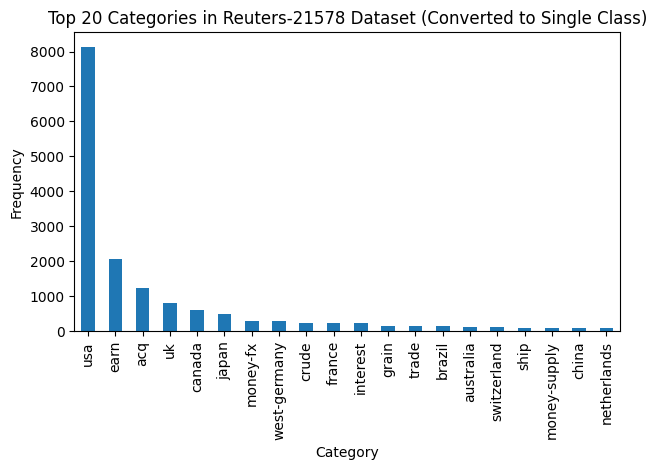

In [ ]:
# Plot the distribution of categories
plt.figure(figsize=(12, 6))
label_df.head(20).plot(kind='bar', x='Category', y='Count', legend=False)
plt.title("Top 20 Categories in Reuters-21578 Dataset (Converted to Single Class)")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Print out the top 20 categories and their counts
print("Top 20 categories by frequency:\n", label_df.head(20))

Top 20 categories by frequency:
         Category  Count
1            usa   8141
5           earn   2072
4            acq   1241
12            uk    816
11        canada    613
30         japan    505
95      money-fx    300
61  west-germany    283
25         crude    249
70        france    238
68      interest    232
35         grain    167
56         trade    148
6         brazil    143
53     australia    138
27   switzerland    113
14          ship    109
10  money-supply    105
66         china     98
88   netherlands     92


In [ ]:
# Check the class distribution in percentage
label_df['Percentage'] = label_df['Count'] / label_df['Count'].sum() * 100
print("Class distribution (in percentage):\n", label_df[['Category', 'Percentage']])

Class distribution (in percentage):
         Category  Percentage
1            usa   37.728242
5           earn    9.602373
4            acq    5.751228
12            uk    3.781629
11        canada    2.840856
..           ...         ...
389  el-salvador    0.009269
441       angola    0.009269
424      lesotho    0.004634
415      linseed    0.004634
366         togo    0.004634

[442 rows x 2 columns]


### Vectorisation

In [ ]:
# Convert Processed Text into TF-IDF Features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_text'])

# Training

### Train Test Split

In [ ]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, df['most_frequent_label'], test_size=0.3, random_state=42)

## Train Naive Bayes Model

In [ ]:
# Initialize Naive Bayes model
nb_model = MultinomialNB()

In [ ]:
# Train the model
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

In [ ]:
# Evaluate the model
print("Naive Bayes Model without SMOTE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Naive Bayes Model without SMOTE:
Accuracy: 0.42477602718566576
                     precision    recall  f1-score   support

                acq       0.52      0.24      0.33       404
         adb-africa       0.00      0.00      0.00         2
           adb-asia       0.00      0.00      0.00         4
        afghanistan       0.00      0.00      0.00         5
           alfonsin       0.00      0.00      0.00         1
            algeria       0.00      0.00      0.00         4
               alum       0.00      0.00      0.00        10
               amex       0.00      0.00      0.00         8
         andriessen       0.00      0.00      0.00         1
             angola       0.00      0.00      0.00         2
            antigua       0.00      0.00      0.00         2
           aqazadeh       0.00      0.00      0.00         1
             aquino       0.00      0.00      0.00         2
          argentina       0.00      0.00      0.00        14
              aruba  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Train Random Forest

In [ ]:
# Initialize Random Forest classifier with class weights
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [ ]:
# Train the Random Forest model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluate the Random Forest model
print("Random Forest Model Evaluation:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))

Random Forest Model Evaluation:
Accuracy: 0.4284831634229225
                     precision    recall  f1-score   support

                acq       0.58      0.02      0.03       404
         adb-africa       0.00      0.00      0.00         2
           adb-asia       0.00      0.00      0.00         4
        afghanistan       0.00      0.00      0.00         5
           alfonsin       0.00      0.00      0.00         1
            algeria       0.00      0.00      0.00         4
               alum       0.00      0.00      0.00        10
               amex       0.00      0.00      0.00         8
         andriessen       0.00      0.00      0.00         1
             angola       0.00      0.00      0.00         2
            antigua       0.00      0.00      0.00         2
           aqazadeh       0.00      0.00      0.00         1
             aquino       0.00      0.00      0.00         2
          argentina       0.30      0.21      0.25        14
              aruba    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

## Random Forest: Hyperparameter Tuning with RandomSearch

In [ ]:
# Define the hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': np.arange(50, 500, 50),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

In [ ]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Setup RandomizedSearchCV to search over the parameter grid
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist,
                                   n_iter=10, cv=3, n_jobs=-1, random_state=42, verbose=2)

In [ ]:
# Train the model with hyperparameter tuning
random_search.fit(X_train, y_train)

In [ ]:
print(f"Best parameters found: {random_search.best_params_}")

Best parameters found: {'n_estimators': np.int64(250), 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Random Forest Model Evaluation with Hyperparameter Tuning:
Accuracy: 0.4442384924312635
                         precision    recall  f1-score   support

                    acq       0.50      0.17      0.26       397
               adb-asia       0.00      0.00      0.00         6
            afghanistan       0.00      0.00      0.00         3
               alfonsin       0.00      0.00      0.00         2
                algeria       0.00      0.00      0.00         4
                   alum       0.50      0.08      0.13        13
                   amex       0.22      0.18      0.20        11
                 angola       0.00      0.00      0.00         2
                antigua       0.00      0.00      0.00         1
                 aquino       0.00      0.00      0.00         3
              argentina       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# Evaluate the model on the test data using the best parameters
y_pred_rf = random_search.predict(X_test)  # Predict using the best model found by RandomizedSearchCV

In [ ]:
# Display the classification report
print("Random Forest Model Evaluation with Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))  # Shows precision, recall, f1-score for each class

Random Forest Model Evaluation with Hyperparameter Tuning:
Accuracy: 0.4442384924312635
                         precision    recall  f1-score   support

                    acq       0.50      0.17      0.26       397
               adb-asia       0.00      0.00      0.00         6
            afghanistan       0.00      0.00      0.00         3
               alfonsin       0.00      0.00      0.00         2
                algeria       0.00      0.00      0.00         4
                   alum       0.50      0.08      0.13        13
                   amex       0.22      0.18      0.20        11
                 angola       0.00      0.00      0.00         2
                antigua       0.00      0.00      0.00         1
                 aquino       0.00      0.00      0.00         3
              argentina       0.36      0.31      0.33        13
                  aruba       0.00      0.00      0.00         1
                    ase       0.00      0.00      0.00         4
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

## Train XG Boost

In [ ]:
# Remove rare classes (fewer than 2 samples)
label_counts = df['most_frequent_label'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_filtered = df[df['most_frequent_label'].isin(valid_labels)].copy()

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df_filtered['label_encoded'] = label_encoder.fit_transform(df_filtered['most_frequent_label'])

In [ ]:
# Train/test split
# Split the data only AFTER filtering rare classes and re-encoding labels.
# This ensures the label indices are consistent, and stratified split won't break due to classes with only 1 sample.
X_train, X_test, y_train, y_test = train_test_split(
    X[df_filtered.index],  # Make sure X matches filtered rows
    df_filtered['label_encoded'],
    test_size=0.3,
    stratify=df_filtered['label_encoded'],
    random_state=42
)

In [ ]:
# Count unique classes in training set
n_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in training set:", n_classes)

Number of unique classes in training set: 440


In [ ]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=n_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [ ]:
# Train the model
xgb_model.fit(X_train, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=436, num_parallel_tree=None, ...)

In [ ]:
# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print("XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_xgb):.4f}")
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_xgb))

XGBoost Model Evaluation:
Accuracy: 0.4628
Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.40      0.22       373
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         9
           7       0.67      0.36      0.47        11
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.50      0.50      0.50        10
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Train BERT Transformer Model

In [ ]:
# Debugging Setup
# Enables clearer CUDA traceback on crash
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# Filter Rare Classes
label_counts = df['most_frequent_label'].value_counts()
valid_labels = label_counts[label_counts >= 5].index  # Only keep classes with at least 5 examples
df_filtered = df[df['most_frequent_label'].isin(valid_labels)].copy()


In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
df_filtered['label'] = label_encoder.fit_transform(df_filtered['most_frequent_label'])
num_labels = df_filtered['label'].nunique()

print("Min label:", df_filtered['label'].min())
print("Max label:", df_filtered['label'].max())
print("Number of labels:", num_labels)

Min label: 0
Max label: 348
Number of labels: 349


In [ ]:
# Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_filtered['processed_text'].tolist(),
    df_filtered['label'].tolist(),
    test_size=0.3,
    stratify=df_filtered['label'],
    random_state=42
)

print("Train labels range:", min(train_labels), max(train_labels))
print("Test labels range:", min(test_labels), max(test_labels))


Train labels range: 0 348
Test labels range: 0 348


In [ ]:
# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels}).map(tokenize, batched=True)

Map:   0%|          | 0/14892 [00:00<?, ? examples/s]

Map:   0%|          | 0/6383 [00:00<?, ? examples/s]

In [ ]:
# Compute Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
# Model Definition
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,     # Smaller batch size to avoid CUDA issues
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42
)

Min label: 0
Max label: 345
Number of labels: 346
Train labels range: 0 345
Test labels range: 0 345


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/14902 [00:00<?, ? examples/s]

Map:   0%|          | 0/6387 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the Model
trainer.train()

<ipython-input-26-94ee40719a89>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: valerie89 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.664300,2.446356,0.474714,0.375753,0.474714,0.410605
2,2.219800,2.233360,0.493502,0.417987,0.493502,0.438212
3,1.973300,2.127571,0.510099,0.448727,0.510099,0.449851
4,1.807700,2.130759,0.512604,0.484552,0.512604,0.482565
5,1.564800,2.162816,0.508690,0.459226,0.508690,0.470275
6,1.469400,2.241997,0.504932,0.476191,0.504932,0.476733


TrainOutput(global_step=11178, training_loss=2.0082531702243314, metrics={'train_runtime': 2374.8022, 'train_samples_per_second': 62.75, 'train_steps_per_second': 7.845, 'total_flos': 1.1916836121010176e+16, 'train_loss': 2.0082531702243314, 'epoch': 6.0})

In [ ]:
# Evaluate the Model
metrics = trainer.evaluate()
print("\nFinal Evaluation Metrics:")
print(metrics)


Final Evaluation Metrics:
{'eval_loss': 2.130758762359619, 'eval_accuracy': 0.5126037263190857, 'eval_precision': 0.4845524763969827, 'eval_recall': 0.5126037263190857, 'eval_f1': 0.482564548884291, 'eval_runtime': 45.4742, 'eval_samples_per_second': 140.453, 'eval_steps_per_second': 4.398, 'epoch': 6.0}


##  Save & Load BERT Model to/from Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define Save Path
save_path = "/content/drive/MyDrive/reuters_classifier"
os.makedirs(save_path, exist_ok=True)

In [ ]:
# Save the trained BERT model and tokenizer for future use
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/reuters_classifier/tokenizer_config.json',
 '/content/drive/MyDrive/reuters_classifier/special_tokens_map.json',
 '/content/drive/MyDrive/reuters_classifier/vocab.txt',
 '/content/drive/MyDrive/reuters_classifier/added_tokens.json',
 '/content/drive/MyDrive/reuters_classifier/tokenizer.json')

### Load the Saved Model for Predictions

In [ ]:
# Load Model and Tokenizer from Google Drive without retraining
load_path = "/content/drive/MyDrive/reuters_classifier"
model = DistilBertForSequenceClassification.from_pretrained(load_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(load_path)


In [ ]:
def create_classification_pipeline(model, tokenizer, use_gpu=True, return_probs=False):
    """
    Create a text classification pipeline with the given model and tokenizer.
    """
    # Make sure model is in evaluation mode and on the correct device
    device = 0 if (use_gpu and torch.cuda.is_available()) else -1
    return TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        device=device,
        return_all_scores=return_probs
    )

def extract_predicted_class_ids(predictions):
    """
    Extract class IDs from pipeline predictions.
    """
    return [int(pred['label'].split('_')[-1]) for pred in predictions]

def decode_predictions(class_ids, label_encoder):
    """
    Decode integer class IDs into original label names.
    """
    return label_encoder.inverse_transform(class_ids)

def predict_texts(texts, model, tokenizer, label_encoder, use_gpu=True, return_probs=False):
    """
    Complete modular prediction pipeline:
    - Create pipeline
    - Predict
    - Decode labels
    """
    pipeline = create_classification_pipeline(model, tokenizer, use_gpu, return_probs)
    predictions = pipeline(texts)

    if return_probs:
        return predictions  # Raw scores for all classes

    class_ids = extract_predicted_class_ids(predictions)
    decoded_labels = decode_predictions(class_ids, label_encoder)
    return decoded_labels


# Model Generalization

# Predict on unseen data

In [ ]:
#generated example texts
unseen_texts = [
    "The stock market responded positively to the company's earnings report.",
    "The agricultural sector saw a sharp drop in wheat exports.",
    "Major oil producers are discussing supply cuts."
]

predicted = predict_texts(unseen_texts, model, tokenizer, label_encoder)

for text, label in zip(unseen_texts, predicted):
    print(f"Text:\n{text}\n→ Predicted Label: {label}\n")


Device set to use cuda:0


Text:
The stock market responded positively to the company's earnings report.
→ Predicted Label: rape-oil

Text:
The agricultural sector saw a sharp drop in wheat exports.
→ Predicted Label: earn

Text:
Major oil producers are discussing supply cuts.
→ Predicted Label: cocoa



/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


### Predict on Twitter Dataset

In [ ]:
def load_and_clean_tweet_data(file_path):
    """
    Load and clean the tweet dataset.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Cleaned DataFrame with columns ['id', 'tweet', 'labels'].
    """
    df = pd.read_csv(file_path, header=None, usecols=[0, 1, 2], names=["id", "tweet", "labels"], encoding="utf-8", engine='python', on_bad_lines='skip')

    # Drop rows with missing or empty labels
    df = df[df['labels'].notna() & (df['labels'].str.strip() != "")]

    # Remove stray semicolons and clean whitespace
    df['labels'] = df['labels'].astype(str).str.replace(";", "", regex=False).str.strip()

    return df

In [ ]:
twitter_df = load_and_clean_tweet_data("/content/drive/MyDrive/mLabel_tweets.csv")
twitter_df.head(10)

,id,tweet,labels
0,ID,tweet,labels
1,1296010336907038720t,@cath__kath AstraZeneca is made with the kidne...,ingredients
2,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
3,1365287445114322946t,We do not need any crazy twisted politician te...,political
4,1376210451068030978t,My mom want me to take the vaccine so bad & I’...,none
5,1355090345676201985t,@CarnellAnita @annaberu Yes who are being cull...,conspiracy
6,1364401704712757250t,@lara_wong @Matthew82069336 @BorisJohnson I fe...,none
7,1315806454926905344t,@johncardillo @MaybeAmes They should open an i...,pharma
8,1309326947693080580t,@MysterySolvent Death people and corona Trump ...,political
9,1371181661384110082t,@ChristopherHahn @ReallyAmerican1 Where is tra...,ineffective


In [ ]:
# Sample 10 random tweets from the dataset
sampled_tweets = df.sample(n=10, random_state=42)['tweet'].tolist()

In [ ]:
# Format into a list of strings
unseen_texts = [str(tweet) for tweet in sampled_tweets]

In [ ]:
# Print the result
print("unseen_texts = [")
for tweet in unseen_texts:
    print(f'    "{tweet}",')
print("]")


In [ ]:
# Make predictions on Twitter dataset
predicted = predict_texts(unseen_texts, model, tokenizer, label_encoder)

for text, label in zip(unseen_texts, predicted):
    print(f"Text:\n{text}\n→ Predicted Label: {label}\n")


Device set to use cuda:0


Text:
@BorisJohnson Yeah thanks for that Boris....my mum....in a care home was given your safe and effective vaccine 10 days ago....today she tested positive.....so which of your statements is a lie?
→ Predicted Label: rape-oil

Text:
Imagine that ! So early days without adequate safety data ! Pfizer launches Covid-19 vaccine delivery trial in four US states https://t.co/X4GaakrRYJ
→ Predicted Label: rape-oil

Text:
@kodytisdale @scdhec And that would be exactly why kids aren't eligible to get the vaccine over here. They haven't run trials.
→ Predicted Label: rape-oil

Text:
@BBCNews Do we know if Pfizer have had their indemnity clause waived in the regulatory approval? In my opinion this is the litmus test for how confident they are that there will be no adverse long term side effects.
→ Predicted Label: rape-oil

Text:
@OOrlova mRNA based vaccines for #covid19 as the one developed by Moderna might be dangerous. They use human ribosomes in cells to produce some #SARSCoV2 proteins. The

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## Finetuning on Twitter Dataset

https://www.kaggle.com/datasets/prox37/twitter-multilabel-classification-dataset

In [ ]:
# Set Device & Seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.manual_seed(42)

In [ ]:
# Load and Clean Data
def load_twitter_data(path):
    df = pd.read_csv(path, header=None, names=["id", "tweet", "labels"], usecols=[0, 1, 2],
                     encoding="utf-8", engine="python", on_bad_lines="skip")
    df = df[df["labels"].notna() & (df["labels"].str.strip() != "")]
    df["labels"] = df["labels"].astype(str).str.replace(";", "", regex=False).str.strip()
    return df

df = load_twitter_data("/content/drive/MyDrive/mLabel_tweets.csv")

# Encode labels first
label_encoder = LabelEncoder()
df["label_raw"] = df["labels"]
df["label"] = label_encoder.fit_transform(df["label_raw"])

# Remove classes that appear only once
label_counts = df["label"].value_counts()
valid_labels = label_counts[label_counts > 1].index
df = df[df["label"].isin(valid_labels)].copy()

# Re-encode after filtering
df["label_raw"] = label_encoder.inverse_transform(df["label"])
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label_raw"])
num_classes = len(label_encoder.classes_)

print("Number of unique classes after filtering:", num_classes)

Number of unique classes after filtering: 105


In [ ]:
# Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["tweet"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [ ]:
# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Create HuggingFace Datasets
train_dataset = Dataset.from_dict({
    "text": train_texts,
    "label": [int(label) for label in train_labels]
}).map(tokenize, batched=True)

test_dataset = Dataset.from_dict({
    "text": test_texts,
    "label": [int(label) for label in test_labels]
}).map(tokenize, batched=True)

# Fix label dtype for CrossEntropyLoss
train_dataset = train_dataset.cast_column("label", Value("int64"))
test_dataset = test_dataset.cast_column("label", Value("int64"))

In [ ]:
# Load and Adapt Pretrained Base Model
from transformers import DistilBertConfig

# Load config and change num_labels
config = DistilBertConfig.from_pretrained(load_path)
config.num_labels = num_classes

# Load the model WITHOUT classification head weights
model = DistilBertForSequenceClassification.from_pretrained(load_path, config=config, ignore_mismatched_sizes=True)
model.to(device)


In [ ]:
#  Metrics
def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_twitter_finetune",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs_twitter_finetune",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Number of unique classes after filtering: 105


Map:   0%|          | 0/3690 [00:00<?, ? examples/s]

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3690 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/923 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/reuters_classifier and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([346]) in the checkpoint and torch.Size([105]) in the model instantiated
- classifier.weight: found shape torch.Size([346, 768]) in the checkpoint and torch.Size([105, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-78-83215dc8afa3>:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.333988,0.469122,0.344890,0.469122,0.391340
2,No log,2.049427,0.538462,0.400670,0.538462,0.454742
3,2.532500,1.950999,0.543879,0.427724,0.543879,0.471611
4,2.532500,1.890400,0.554713,0.448591,0.554713,0.491197
5,1.663700,1.882896,0.563380,0.452177,0.563380,0.497338


Final Evaluation on Twitter Data: {'eval_loss': 1.8828961849212646, 'eval_accuracy': 0.5633802816901409, 'eval_precision': 0.4521768044001781, 'eval_recall': 0.5633802816901409, 'eval_f1': 0.4973381146895121, 'eval_runtime': 1.4884, 'eval_samples_per_second': 620.121, 'eval_steps_per_second': 19.484, 'epoch': 5.0}


('/content/drive/MyDrive/twitter_finetuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/twitter_finetuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/twitter_finetuned_bert/vocab.txt',
 '/content/drive/MyDrive/twitter_finetuned_bert/added_tokens.json',
 '/content/drive/MyDrive/twitter_finetuned_bert/tokenizer.json')

In [ ]:
# Evaluate
metrics = trainer.evaluate()
print("Final Evaluation on Twitter Data:", metrics)

Final Evaluation on Twitter Data: {'eval_loss': 1.8828961849212646, 'eval_accuracy': 0.5633802816901409, 'eval_precision': 0.4521768044001781, 'eval_recall': 0.5633802816901409, 'eval_f1': 0.4973381146895121, 'eval_runtime': 1.453, 'eval_samples_per_second': 635.256, 'eval_steps_per_second': 19.959, 'epoch': 5.0}


In [ ]:
# Save Model
save_path = "/content/drive/MyDrive/twitter_finetuned_bert"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/twitter_finetuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/twitter_finetuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/twitter_finetuned_bert/vocab.txt',
 '/content/drive/MyDrive/twitter_finetuned_bert/added_tokens.json',
 '/content/drive/MyDrive/twitter_finetuned_bert/tokenizer.json')

### Make predictions

In [ ]:
#generated example texts
unseen_texts = [
    "Vaccines have many side effects including blood clots.",
    "I don't trust pharmaceutical companies making money off this.",
    "It is a rushed and untested experiment.",
    "Vaccines are unnecessary because we have natural immunity."
]

predicted = predict_texts(unseen_texts, model, tokenizer, label_encoder)

for text, label in zip(unseen_texts, predicted):
    print(f"Text:\n{text}\n→ Predicted Label: {label}\n")

Device set to use cuda:0


Text:
Vaccines have many side effects including blood clots.
→ Predicted Label: side-effect

Text:
I don't trust pharmaceutical companies making money off this.
→ Predicted Label: pharma

Text:
It is a rushed and untested experiment.
→ Predicted Label: rushed

Text:
Vaccines are unnecessary because we have natural immunity.
→ Predicted Label: ineffective



/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
